In [1]:
import os
import glob
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
# %matplotlib widget

from iminuit import Minuit

from scipy.stats       import rv_continuous
from scipy.interpolate import interp1d

from pdf_manager import pdf, Extpdf, compute_chi2dof

import invisible_cities.core.system_of_units as units

plt.rcParams["font.size"]      = 15
plt.rcParams["font.family"]    = "sans-serif"
plt.rcParams["font.monospace"] = "Computer Modern Sans Serif"
plt.rcParams["figure.max_open_warning"] = 50

In [2]:
indir = os.path.expandvars("$HOME/NEXT/DATA/")
filenames = sorted(glob.glob(indir + "/esmeralda_combined_*_*.h5"))

def get_background_and_component(filename):
    names = filename.split("/")[-1].split("_")
    return (names[-2], names[-1].split(".")[0])

In [3]:
filtered_summaries = []

for filename in filenames:
    
    background, component = get_background_and_component(filename)
    
    summary_ = pd.read_hdf(filename, "Summary/Events")
    Ntot = len(summary_)
    summary_ = summary_[~summary_["evt_out_of_map"]]
    print(background, component, "In map selection:", int(len(summary_)/Ntot*100), "%")

    summary_["background"] = background
    summary_["component"]  = component
    
    filtered_summaries.append(summary_)
    
summary = pd.concat(filtered_summaries)

208Tl LIGHTTUBE In map selection: 95 %
208Tl SAPPHIREWINDOW In map selection: 98 %
208Tl SIPMBOARD In map selection: 97 %
214Bi LIGHTTUBE In map selection: 78 %
214Bi SAPPHIREWINDOW In map selection: 98 %
214Bi SIPMBOARD In map selection: 97 %


In [4]:
filename = glob.glob(indir + "/esmeralda_combined_0nubb.h5")[0]

summary_ = pd.read_hdf(filename, "Summary/Events")
Ntot = len(summary_)
summary_ = summary_[~summary_["evt_out_of_map"]]
print("0nubb","In map selection:", int(len(summary_)/Ntot*100), "%")

summary_["background"] = "0nubb"
summary_["component"]  = "0nubb"

summary = pd.concat([summary, summary_])

0nubb In map selection: 96 %


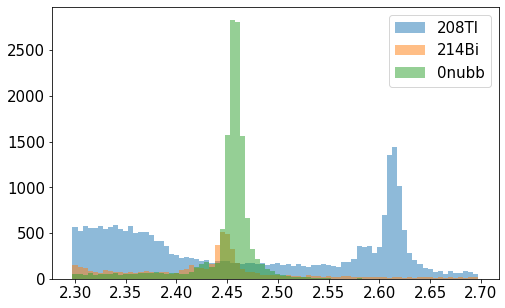

In [5]:
x1, x2, dx = 2.3, 2.7, 0.005
bins = np.arange(x1, x2, dx)

fig, ax = plt.subplots(1, 1, figsize=[8, 5])
for background in summary["background"].unique():
    sel = summary["background"] == background
    energy = summary[sel]["evt_energy"].values
    
    h, _ = np.histogram(energy, bins=bins)
    
    ax.bar(bins[:-1], h, width=dx, alpha=0.5, label=background)
    ax.set_yscale("linear")
    ax.legend()

# Create Extended pdf

In [6]:
x1, x2, dx = 2.3, 2.7, 0.005
bins = np.arange(x1, x2, dx)
binc = (bins[1:] + bins[:-1])/2.

pdf_collection = {}
for background in summary["background"].unique():
    
    sel = summary["background"] == background
    energy = summary[sel]["evt_energy"].values
    
    h, _ = np.histogram(energy, bins=bins)
#     p = h/(np.sum(h)*dx)
    pdf_collection[background] = pdf(name=background, numpdf=(binc, h))        

In [7]:
PDF = Extpdf(pdf_collection)
PDF.args_order

{0: '208Tl', 1: '214Bi', 2: '0nubb'}

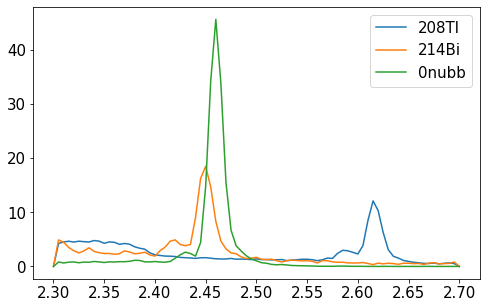

In [8]:
x = np.arange(x1, x2, dx)

fig, ax = plt.subplots(1, 1, figsize=[8, 5])
for i in PDF.args_order:
    ns = [0]*len(PDF.args_order)
    ns[i] = 1
    
    plt.plot(x, PDF.pdf(x, *ns), label=PDF.args_order[i])
plt.legend();

# Test fits

First we present and example of fit for a given set of activities. The procedure is as follow:
- Set the activities
- Compute the number of events for each component and randomly select them from data
- Select the energy range of interest and compute the number of events for each component in this range
- Perform the fit

Then we do exactly the same for multiple experiments to check the fit result compatibility.

In [9]:
# activities (mBq) 1Bq = 1/s
A_214Bi = 10  * units.mBq
A_208Tl = 10  * units.mBq
A_0nubb = 0.5 * units.mBq

total_time = 10 * units.day

number_events = {"214Bi": int(A_214Bi*total_time), 
                 "208Tl": int(A_208Tl*total_time),
                 "0nubb": int(A_0nubb*total_time)}

# generate experiment
experiment = []
for background, df in summary.groupby("background"):    
    experiment.append(df.sample(n=number_events[background]))
experiment = pd.concat(experiment).sample(frac=1)

In [10]:
# select energy range
roi = experiment[(x1<=experiment["evt_energy"])&(experiment["evt_energy"]<=x2)]
energy = roi["evt_energy"].values
number_events_roi = dict(roi.groupby("background").apply(lambda df: len(df)))

logL = PDF.eval_logL(energy)

In [11]:
#fit
guess = [len(energy)]*len(PDF.args_order)
m = Minuit(logL, *guess)
m.errordef = Minuit.LIKELIHOOD
m.limits = [(0, 1.2*len(energy))]*len(PDF.args_order)
m.migrad()
m.hesse();

print("{:<8} | {:<8} | {:<8}".format("Name", "Expected", "Result"))
print()
for i in PDF.args_order:
    name = PDF.args_order[i]
    try:
        expected = number_events_roi[name]
    except KeyError:
        expected = 0
    result   = int(m.values[i])
    err      = int(m.errors[i])
    print("{:<8} | {:<8} | {:<8}+- {:<6}".format(name, expected, result, err))
    
chi2dof = compute_chi2dof(energy, bins, PDF.pdf, list(m.values))
print()
print("chi2/dof =", round(chi2dof, 3))

Name     | Expected | Result  

208Tl    | 3417     | 3451    +- 80    
214Bi    | 1178     | 992     +- 80    
0nubb    | 304      | 394     +- 40    

chi2/dof = 1.41


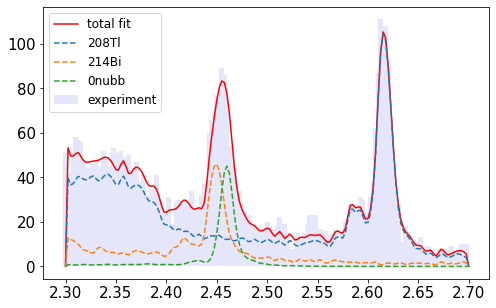

In [12]:
dx_ = dx/2.
x = np.arange(x1, x2, dx_)

fig, ax = plt.subplots(1, 1, figsize=[8, 5])
ax.plot(x, np.sum(m.values)*dx_*PDF.pdf(x, *m.values), c="r", label="total fit")
for i in PDF.args_order:
    p = PDF.collection[PDF.args_order[i]]
    ax.plot(x, m.values[i]*dx_*p.pdf(x), label=PDF.args_order[i], linestyle="--")

h, _ = np.histogram(energy, bins=x)
ax.bar(x[:-1], h, width=dx, color="lavender", alpha=1, label="experiment")
ax.legend(fontsize=12);

In [ ]:
n_exp = 1000
n = 1

results = []
errors  = []
chi2s   = []
while n<=n_exp:
    print("Experiment", n, "/", n_exp, end="\r")
    
    # generate experiment
    experiment = []
    for background, df in summary.groupby("background"):    
        experiment.append(df.sample(n=number_events[background]))
    experiment = pd.concat(experiment).sample(frac=1)

    # select energy range
    roi = experiment[(x1<=experiment["evt_energy"])&(experiment["evt_energy"]<=x2)]
    energy = roi["evt_energy"].values
    number_events_roi = dict(roi.groupby("background").apply(lambda df: len(df)))
    logL = PDF.eval_logL(energy)
    #fit
    guess = [len(energy)]*len(PDF.args_order)
    m = Minuit(logL, *guess)
    m.errordef = Minuit.LIKELIHOOD
    m.limits = [(0, 1.2*len(energy))]*len(PDF.args_order)
    m.migrad()
    m.hesse();

    chi2dof = round(compute_chi2dof(energy, bins, PDF.pdf, list(m.values)), 3)
    
    results.append(list(m.values))
    errors .append(list(m.errors))
    chi2s  .append(chi2dof)
    
    n+=1
    
results = np.array(results)
errors  = np.array(errors)
chi2s   = np.array(chi2s)

In [176]:
plt.figure()
plt.hist(chi2s, bins=100);

/Users/gonzalo/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 50 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [177]:
def gauss_pdf(x, mu, sig):
    return (1/sig)*(1/(2*np.pi)**0.5)*np.exp(-((x-mu)/sig)**2/2)

def gauss_logL(x):
    n = len(x)
    def logL(mu, sig):
        logL_ = -n*np.log(sig) -(1/2.)*np.sum(((x-mu)/sig)**2)
        return -logL_
    return logL

In [193]:
i = 0
x = results[:, i]
logL = gauss_logL(x)

guess = [np.mean(x), np.std(x)]
m = Minuit(logL, *guess)
m.errordef = Minuit.LIKELIHOOD
m.limits = [(min(x), max(x)), (0, max(x)-min(x))]
m.migrad()
m.hesse()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 4693                       │              Nfcn = 37               │
│ EDM = 2.57e-17 (Goal: 0.1)       │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu   │ 3.3501e3  │ 0.0021e3  │            │            │ 3152.58 │ 3629.36 │       │
│ 1 │ sig  │   66.5    │    1.5    │            │            │    0    │ 476.779 │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬───────────────────┐
│     │       mu      sig │
├─────┼───────────────────┤
│  mu │     4.43 0.000212 │
│ sig │ 0.000212     2.21 │
└─────┴───────────────────┘

In [194]:
dx = 5
bins = np.arange(min(x), max(x), dx) 

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=[8, 5])
fig.suptitle(PDF.args_order[i])
h, _ = np.histogram(x, bins=bins)
ax0.bar(bins[:-1], h, width=dx, alpha=0.5)
ax0.plot(bins, gauss_pdf(bins, *m.values)*dx*np.sum(h), c="r")

ax1.hist(errors[:, i], bins=100);

/Users/gonzalo/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 50 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …